<a href="https://colab.research.google.com/github/thiagofst/kepler/blob/main/kepler_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Google Drive

You can delete this cell or create a new folder on your initial Drive named "lightkurve/kepler-10"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/lightkurve/kepler-10/')

Mounted at /content/drive


### Packages

In [ ]:
!pip install lightkurve
import lightkurve as lk

     |████████████████████████████████| 247 kB 5.3 MB/s 
     |████████████████████████████████| 41 kB 186 kB/s 
     |████████████████████████████████| 98 kB 7.2 MB/s 
     |████████████████████████████████| 4.5 MB 39.0 MB/s 
     |████████████████████████████████| 802 kB 39.1 MB/s 
     |████████████████████████████████| 54 kB 2.6 MB/s 
     |████████████████████████████████| 3.6 MB 35.2 MB/s 
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11376 sha256=59d8eec3dbeb97fe1a1e66e5e641e936b24c47f9381cc35aa5d1d05aaab8672b
  Stored in directory: /root/.cache/pip/wheels/93/08/0c/1b9866c35c8d3f136d100dfe88036a32e0795437daca089f70
  Created wheel for memoization: filename=memoization-0.4.0-py3-none-any.whl size=50466 sha256=beaf08bc33caace21d6663a4a576057953dd4197fc1124d456f5927d260846f7
  Stored in directory: /root/.cache/pip/wheels/38/f7/65/161985e7311dd484a23b3a5c9149995dbf11db6cede602e7ef
  Created wheel for oktopus: filename=oktopus-0.1.2-py3-none-any.whl size=12778 s

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
!pip install corner exoplanet pymc3_ext celerite2

import corner
import exoplanet as xo
import arviz as az
import pymc3 as pm
import pymc3_ext as pmx
import theano

import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess

     |████████████████████████████████| 41 kB 100 kB/s 
     |████████████████████████████████| 864 kB 10.4 MB/s 
     |████████████████████████████████| 211 kB 38.0 MB/s 


### Identifying transiting exoplanet signals in a light curve

In [ ]:
obj = input('Target name: ')
mission = input('Mission: (Kepler, K2 or TESS) ')

Target name: Kepler-10
Mission: (Kepler, K2 or TESS) Kepler


In [ ]:
result = lk.search_lightcurve(f'{obj}', 
                              author = f'{mission}', 
                              cadence = 'long')

lc_collection = result.download_all()

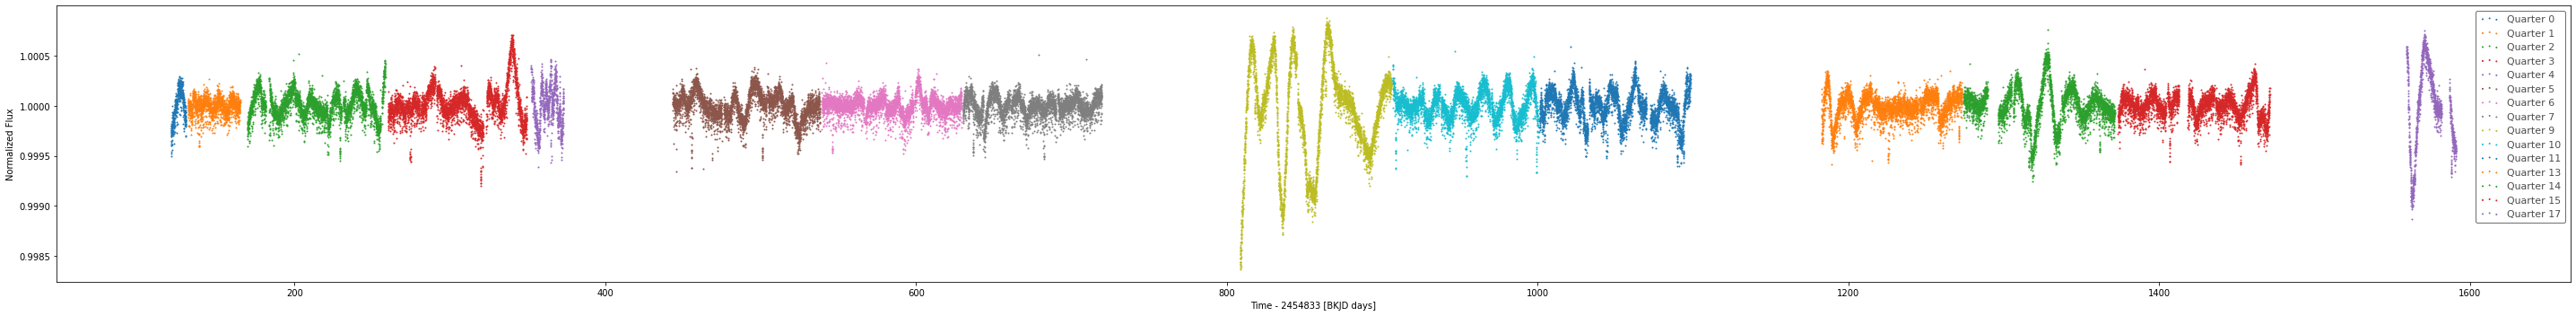

In [ ]:
fig, ax = plt.subplots(figsize = (40, 5))

for lc in lc_collection:
  lc.normalize().remove_outliers().scatter(ax = ax, label = f'Quarter {lc.quarter}')

plt.tight_layout()
plt.savefig(f'{obj}.pdf')

Note that each observation has a different offset, so to successfully search in this light curve for transits, we first need to **normalise** and **flatten** the full observation. This can be performed with `.stitch()` method:

*Stitch all light curves in the collection into a single LightCurve*.

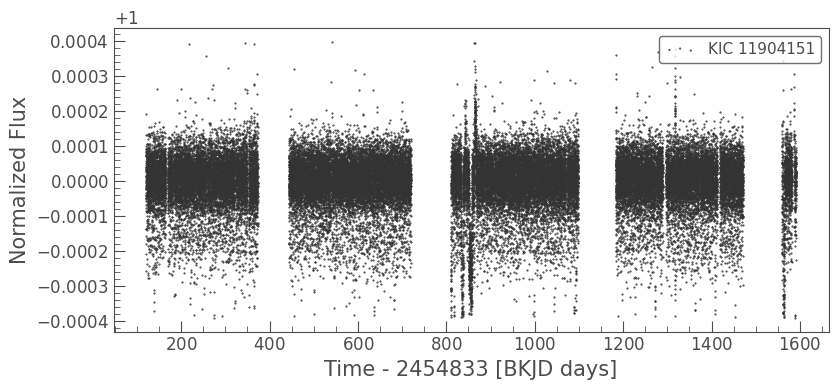

In [ ]:
lc = lc_collection.stitch().flatten(
                                    # window_length = 901
                                    ).remove_outliers()

# lc.errorbar(fmt = '.k', ecolor = 'grey')
lc.scatter(s = 1.0)

plt.tight_layout()
plt.savefig(f'{obj}_lc.pdf')

`Lightkurve` has two types of periodogram available to analyse periodic trends in light curves: `LombScarglePeriodogram` and `BoxLeastSquaresPeriodogram`


#### Box Least Squares

To create a `BoxLeastSquaresPeriodogram` object, use the `LightCurve` method `.to_periodogram()` and pass in the string `bls` to specify the type of periodogram object you want to create. This method also optionally takes an array of periods (in days) to search, which we will set from 1 to 100 days to limit our search to short-period planets.

Documentation: https://docs.lightkurve.org/reference/api/lightkurve.periodogram.LombScarglePeriodogram.from_lightcurve.html#lightkurve.periodogram.LombScarglePeriodogram.from_lightcurve

In [ ]:
periods = np.linspace(1, 100, 10000) # 10000 periods evenly distributed between 1 and 100 days

bls = lc.to_periodogram(method = 'bls', #or 'ls' for Lomb-Scargle
                        period = periods, 
                        frequency_factor = 500)

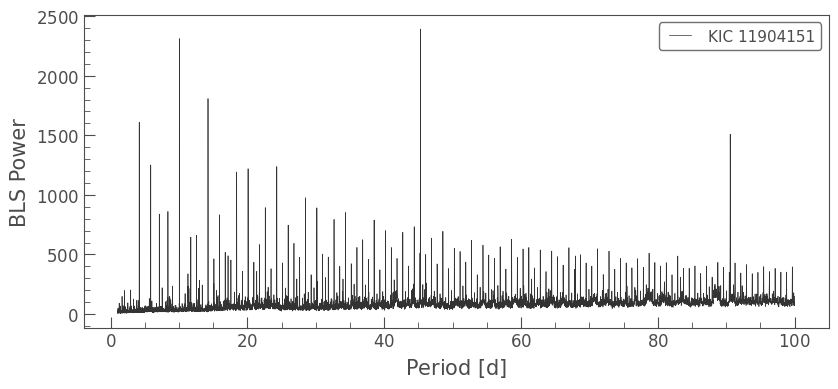

In [ ]:
bls.plot()

plt.tight_layout()
plt.savefig(f'{obj}_periodogram.pdf')

The plot above shows the power, or the likelihood of the BLS fit, for each of the periods in the array we passed in. *This plot shows a handful of high-power peaks at discrete periods, which is a good sign that transit has been identified*. The highest power spike shows the most likely period, while the lower power spikes are fractional harmonics of the period, for example, P/2, P/3, P/4, etc. 

We can pull out the most likely BLS parameters by taking their values at maximum power, which we will refer to this transiting object as "planet b"

In [ ]:
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power

planet_b_period

<Quantity 45.2970297 d>

Compare it to the literature period: https://en.wikipedia.org/wiki/Kepler-10

Phase-fold the light curve using these values and plot it.

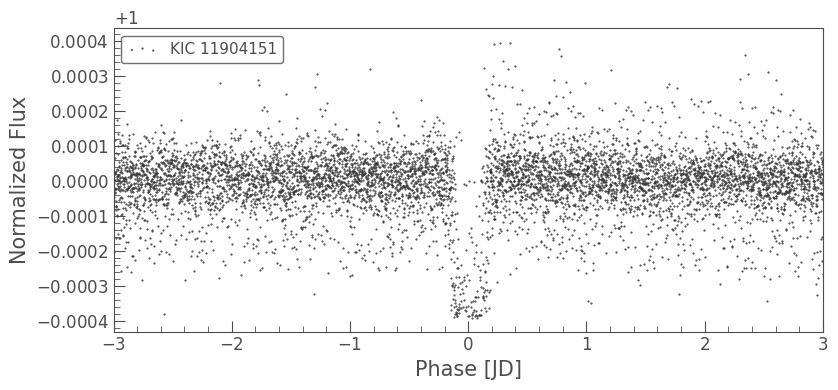

In [ ]:
ax = lc.fold(period = planet_b_period, 
             epoch_time = planet_b_t0).scatter(s = 1)

ax.set_xlim(-3, 3)

plt.tight_layout()
plt.savefig(f'{obj}_phased.pdf')

It shows a strong transit signal with the identified period and transit time of maximum BLS power. 

### Markov Chain Monte Carlo (MCMC) simulations with `PyMC3` and orbital model with `exoplanet`

See also https://gallery.exoplanet.codes/tutorials/quick-tess/

In [ ]:
period_ = bls.period_at_max_power
t0_ = bls.transit_time_at_max_power
duration_ = bls.duration_at_max_power
depth_ = bls.depth_at_max_power

print('Period: %.4f days\nTransit time: %.7f (- 2454833 [BKJD days])\nTransit duration: %.4f days\nNormalised transit depth: %.4f'%(period_.value, t0_.value, duration_.value, depth_.value))

Period: 45.2970 days
Transit time: 138.6241465 (- 2454833 [BKJD days])
Transit duration: 0.2500 days
Normalised transit depth: 0.0002


#### `PyMC3` orbits modelling

In [ ]:
x = np.ascontiguousarray(lc.time.value, dtype = np.float64)
y = np.ascontiguousarray(1e3 * (lc.flux - 1), dtype = np.float64)
yerr = np.ascontiguousarray(1e3 * lc.flux_err, dtype = np.float64)

In [ ]:
transit_mask = (
    np.abs(
        (x - t0_.value + 0.5 * period_.value) % period_.value - 0.5 * period_.value
    )
    < 0.25
)

x = np.ascontiguousarray(x[transit_mask])
y = np.ascontiguousarray(y[transit_mask])
yerr = np.ascontiguousarray(yerr[transit_mask])

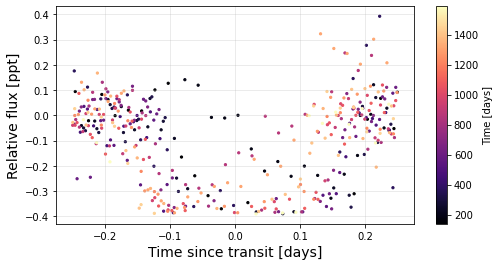

In [ ]:
plt.figure(figsize = (8, 4))

x_fold = (
    x - t0_.value + 0.5 * period_.value
) % period_.value - 0.5 * period_.value

plt.grid(alpha = 0.3)
plt.scatter(x_fold, y, c = x, s = 5, cmap = plt.cm.magma)
plt.xlabel('Time since transit [days]', fontsize = 14)
plt.ylabel('Relative flux [ppt]', fontsize = 14)
plt.colorbar(label = 'Time [days]')

#### The probabilistic model

https://docs.pymc.io/en/v3/api/distributions/continuous.html#continuous

https://docs.exoplanet.codes/en/v0.2.0/tutorials/gp/

`pm.InverseGamma` probability density function (pdf) distribution:

$$
f(x\vert\alpha,\beta) = \frac{\beta^\alpha}{\Gamma(\alpha)} x^{-\alpha -1}\mbox{exp}\left(\frac{-\beta}{x}\right)
$$

`pm.Normal` pdf:

$$
f(x\vert\mu,\tau) = \sqrt{\frac{\tau}{2\pi}}\mbox{exp}\left(-\frac{\tau}{2}(x-\mu)^2\right), \quad \tau := \frac{1}{\sigma^2}
$$

In [ ]:
with pm.Model() as model:

    # STELLAR PARAMETERS
    mean = pm.Normal('mean', mu = 0, sigma = 10)
    u = xo.QuadLimbDark('u')
    star_params = [mean, u]

    # GAUSSIAN PROCESS NOISE MODEL
    sigma = pm.InverseGamma('sigma', alpha = 3.0, beta = 2 * np.median(yerr))
    log_sigma_gp = pm.Normal('log_sigma_gp', mu = 0.0, sigma = 10.0)
    
    log_rho_gp = pm.Normal('log_rho_gp', mu = np.log(10.0), sigma = 10.0)
    
    kernel = terms.SHOTerm(
        sigma=tt.exp(log_sigma_gp), rho=tt.exp(log_rho_gp), Q=1.0 / 3
    )

    noise_params = [sigma, log_sigma_gp, log_rho_gp]

    # PLANET PARAMETERS
    # RADIUS OF THE PLANET IN STELLAR RADII
    log_ror = pm.Normal(
        'log_ror', mu = 0.5 * np.log(depth_.value * 1e-3), sigma = 10.0
    )
    ror = pm.Deterministic('ror', tt.exp(log_ror))

    # ORBITAL PARAMETERS
    # A TRANSIT IS MODELLED BY period, t0, duration, impact parameter AND depth
    log_period = pm.Normal('log_period', mu = np.log(period_.value), sigma = 0.1)
    period = pm.Deterministic('period', tt.exp(log_period)) # ORBITAL PERIOD

    t0 = pm.Normal('t0', mu = t0_.value, sigma = 0.1) # TRANSIT TIME REFERENCE

    log_depth = pm.Normal('log_delta', mu = np.log(depth_.value), sigma = 0.1)
    depth = pm.Deterministic('depth', tt.exp(log_depth))

    log_dur = pm.Normal('log_dur', mu = np.log(0.1), sigma = 10.0)
    dur = pm.Deterministic('dur', tt.exp(log_dur)) # TRANSIT DURATION

    b = xo.distributions.ImpactParameter('b', ror = ror) # IMPACT PARAMETER

    # SET UP THE ORBIT
    orbit = xo.orbits.KeplerianOrbit(period = period, 
                                     duration = dur, 
                                     t0 = t0, 
                                     b = b)

    # WE ARE GOING TO TRACK THE IMPLIED DENSITY FOR PLOTTING PURPOSES
    pm.Deterministic('rhor_circ', orbit.rho_star)

    # SET UP THE MEAN TRANSIT MODEL
    star = xo.LimbDarkLightCurve(u)
    lc_model = mean + 1e3 * tt.sum(
        star.get_light_curve(orbit = orbit, 
                             r = ror, 
                             t = x), axis = -1)

    # THE GAUSSIAN PROCESS OBSERVATION MODEL
    gp = GaussianProcess(kernel, 
                         t = x, 
                         diag = yerr ** 2 + sigma ** 2)
    gp.marginal('obs', observed = y - lc_model) # CONDITION TO OBSERVATIONS

    # DOUBLE CHECK THAT EVERYTHING LOOKS GOOD 
    # WE SHOULDN'T SEE ANY NaNs
    print(model.check_test_point())

    # OPTIMISE THE MODEL
    map_soln = model.test_point
    map_soln = pmx.optimize(map_soln, [sigma])
    map_soln = pmx.optimize(map_soln, [ror, b, dur, depth])
    map_soln = pmx.optimize(map_soln, noise_params)
    map_soln = pmx.optimize(map_soln, star_params)
    map_soln = pmx.optimize(map_soln)

/usr/local/lib/python3.7/dist-packages/exoplanet/orbits/keplerian.py:113: UserWarning: When using the 'duration' parameter in KeplerianOrbit, the 'ror' parameter should also be provided.
  UserWarning,
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar

mean                 -3.22
u_quadlimbdark__     -2.77
sigma_log__          -0.53
log_sigma_gp         -3.22
log_rho_gp           -3.22
log_ror              -3.22
log_period            1.38
t0                    1.38
log_delta             1.38
log_dur              -3.22
b_impact__           -1.39
obs                -871.22
Name: Log-probability of test_point, dtype: float64


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
optimizi

message: Optimization terminated successfully.
logp: -887.867506075073 -> 63.85548246264214
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot const

message: Desired error not necessarily achieved due to precision loss.
logp: 63.85548246264214 -> 159.3926324340491
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): C

message: Optimization terminated successfully.
logp: 159.3926324340491 -> 318.7030754210879
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot const

message: Optimization terminated successfully.
logp: 318.7030754210879 -> 332.3738735076773
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar

message: Desired error not necessarily achieved due to precision loss.
logp: 332.3738735076773 -> 458.04197465352826


In [ ]:
with model:
    lc_pred = pmx.eval_in_model(lc_model, map_soln)
    gp_pred = pmx.eval_in_model(gp.predict(y - lc_pred), map_soln)

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0


Sampling

In [ ]:
with model:
    trace = pmx.sample(
        tune = 1000,
        draws = 1000,
        start = map_soln,
        chains = 2,
        cores = 2,
        return_inferencedata=True,
        random_seed=[286923464, 464329682] # 2 chains, 2 random seeds
    )

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 152 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt):

Take a look at the `summary` function. The main column here is `r_hat`, which shows the [Gelman-Rubin statistics](https://arxiv.org/abs/1812.09384), and it should be close to 1 to characterise a good fit quality. See also https://bookdown.org/rdpeng/advstatcomp/monitoring-convergence.html#gelman-rubin-statistic

In [ ]:
smry = az.summary(
    trace, 
    var_names = ['^(?!rv_plot).*'], 
    filter_vars = 'regex'
)

smry

mean     sd   hdi_3%  ...  ess_bulk  ess_tail  r_hat
mean            0.012  0.012   -0.010  ...    1586.0    1333.0   1.00
log_sigma_gp   -2.437  0.082   -2.598  ...    1558.0    1395.0   1.00
log_rho_gp     -1.313  0.277   -1.834  ...     888.0     602.0   1.00
log_ror        -3.910  0.053   -4.033  ...     243.0     106.0   1.01
log_period      3.813  0.000    3.813  ...    1865.0    1501.0   1.00
t0            138.677  0.001  138.675  ...    1784.0     992.0   1.00
log_delta      -8.333  0.097   -8.518  ...    1634.0    1346.0   1.00
log_dur        -1.272  0.011   -1.292  ...     244.0     180.0   1.01
u[0]            0.421  0.312    0.000  ...     758.0    1115.0   1.00
u[1]            0.143  0.344   -0.526  ...     313.0     179.0   1.01
sigma           0.036  0.007    0.024  ...     648.0     359.0   1.00
ror             0.020  0.001    0.018  ...     243.0     106.0   1.01
period         45.294  0.000   45.294  ...    1865.0    1501.0   1.00
depth           0.000  0.000    0.000  ...    1634.0    1346.0   1.00
dur             0.280  0.003    0.275  ...     244.0     180.0   1.01
b               0.801  0.163    0.417  ...     249.0      86.0   1.01
rhor_circ       0.257  0.230    0.090  ...     258.0      86.0   1.01

[17 rows x 9 columns]

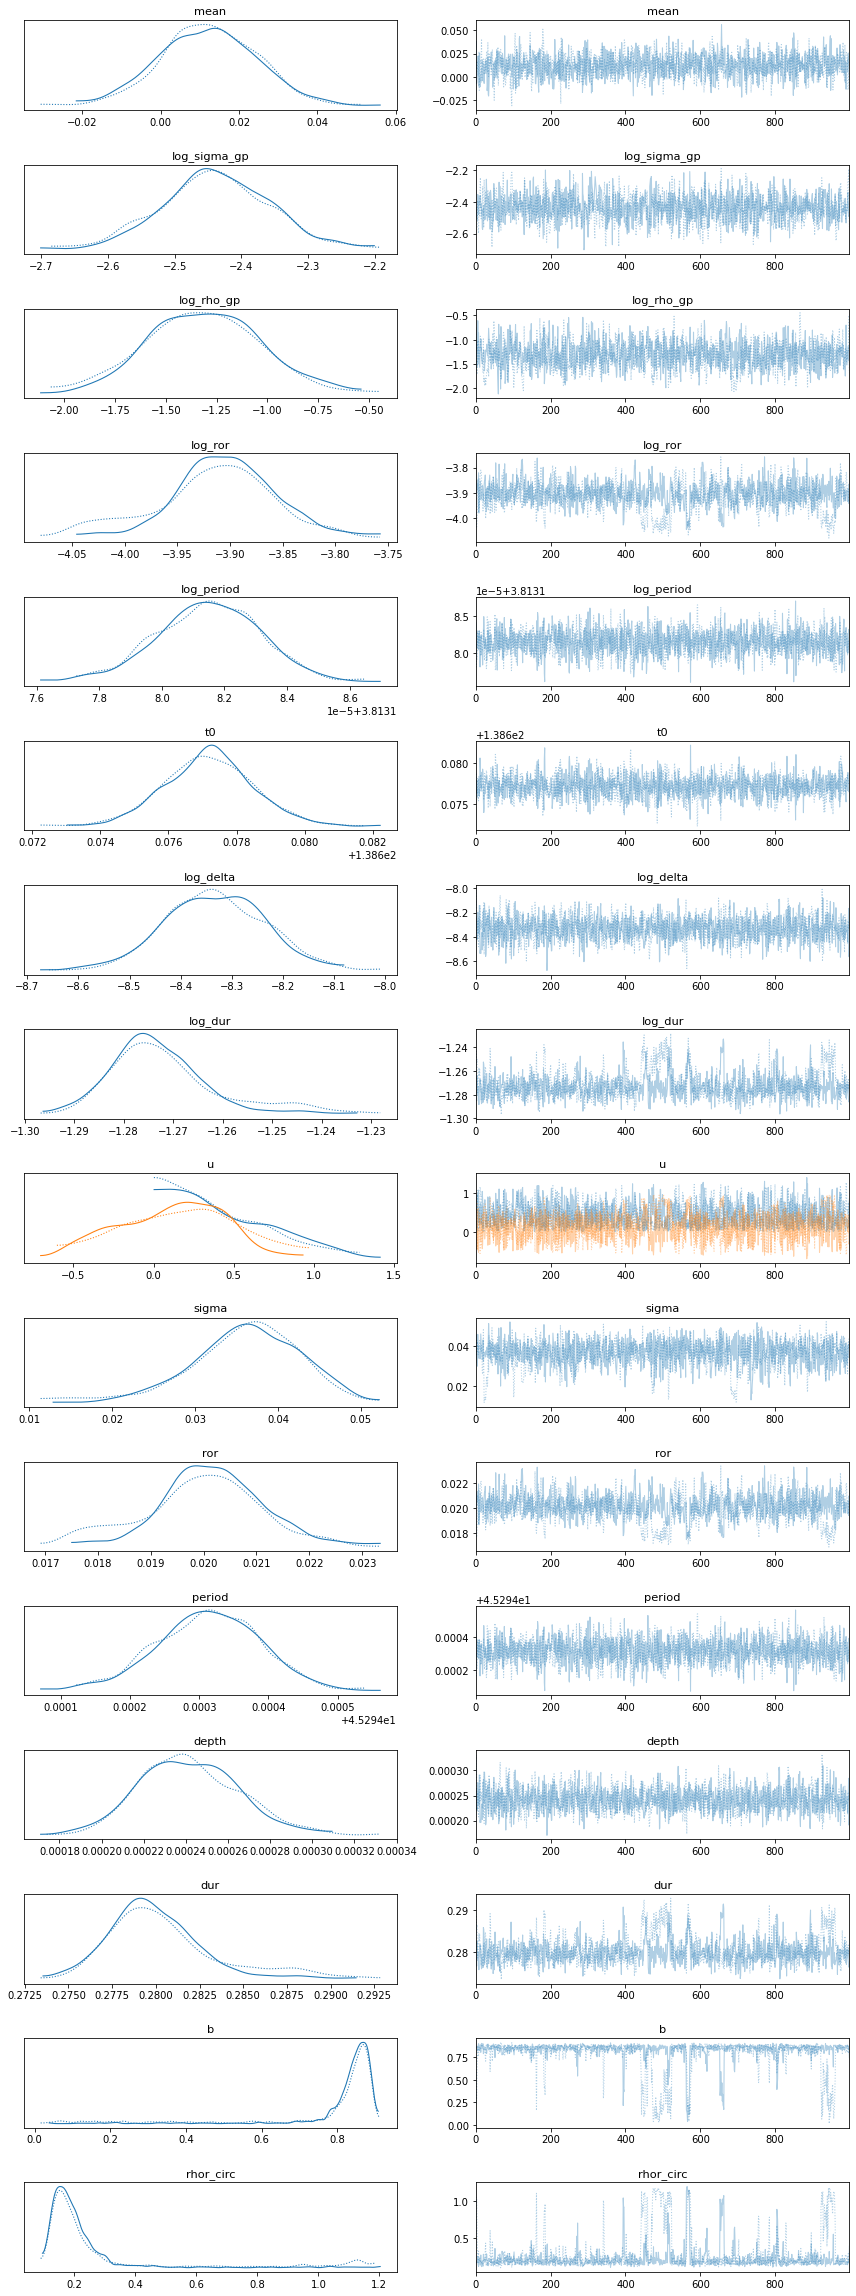

In [ ]:
_ = az.plot_trace(trace)

plt.tight_layout()
plt.savefig(f'{obj}_arviz_trace.pdf')

The posterior covariances:

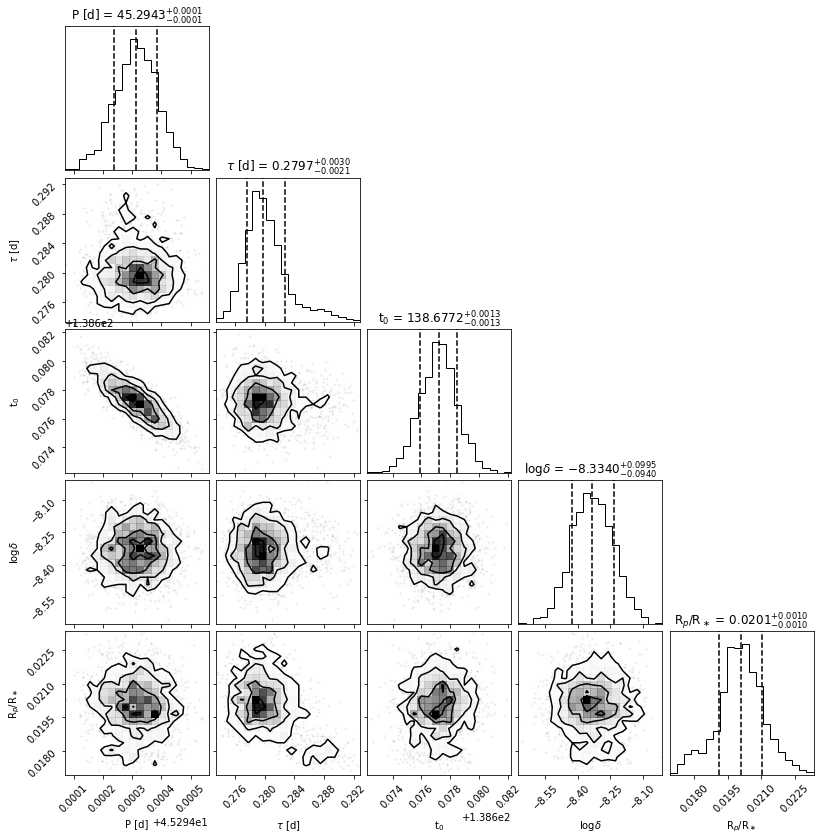

In [ ]:
_ = corner.corner(trace, 
                  var_names = ['period', 'dur', 't0', 'log_delta', 'ror'],
                  quantiles = [0.16, 0.5, 0.84], 
                  show_titles = True,
                  title_fmt = '.4f',
                  labels = ['P [d]', r'$\tau$ [d]', r't$_0$', r'$\log\delta$', r'R$_p$/R$_\ast$']
                  )

# plt.tight_layout()
plt.savefig(f'{obj}_corner.pdf')

In [ ]:
periods = np.percentile(trace['posterior']['period'], [16, 50, 84])
periods_q = np.diff(periods)

durations = np.percentile(trace['posterior']['dur'], [16, 50, 84])
durations_q = np.diff(durations)

ror = np.percentile(trace['posterior']['ror'], [16, 50, 84])
ror_q = np.diff(ror)

t0s = np.percentile(trace['posterior']['t0'], [16, 50, 84])
t0_q = np.diff(t0s)

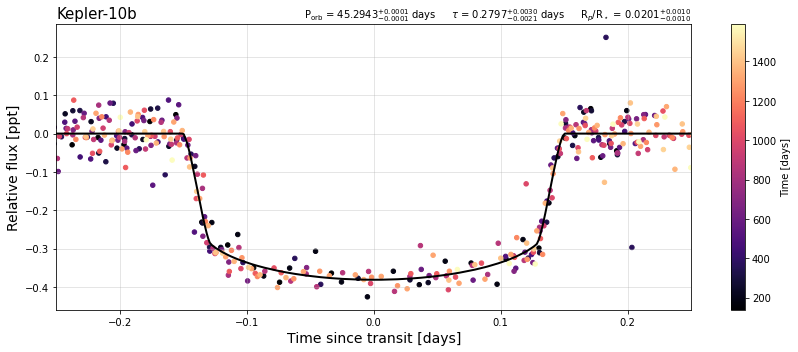

In [ ]:
plt.figure(figsize = (12, 5))

plt.grid(alpha = 0.4)

x_fold = (x - map_soln['t0'] + 0.5 * map_soln['period']) % map_soln[
    'period'
] - 0.5 * map_soln['period']

inds = np.argsort(x_fold)

plt.scatter(x_fold, 
            y - gp_pred - map_soln['mean'], 
            c = x, 
            s = 20, 
            cmap = plt.cm.magma)

plt.plot(x_fold[inds], 
         lc_pred[inds] - map_soln['mean'], 
         'k', 
         lw = 2.0)


plt.title(f'{obj}b', fontsize = 15, loc = 'left')
plt.title(r'P$_\mathrm{orb}$ = %.4f$^{+%.4f}_{-%.4f}$ days $\quad$ $\tau$ = %.4f$^{+%.4f}_{-%.4f}$ days $\quad$ R$_p$/R$_\star$ = %.4f$^{+%.4f}_{-%.4f}$'%(
          periods[1], periods_q[1], periods_q[0], 
          durations[1], durations_q[1], durations_q[0], 
          ror[1], ror_q[1], ror_q[0]), loc = 'right', fontsize = 10)

plt.xlabel('Time since transit [days]', fontsize = 14)
plt.ylabel('Relative flux [ppt]', fontsize = 14)
plt.colorbar(label = 'Time [days]')
_ = plt.xlim(-0.25, 0.25)

plt.tight_layout()
plt.savefig(f'{obj}_model.pdf')

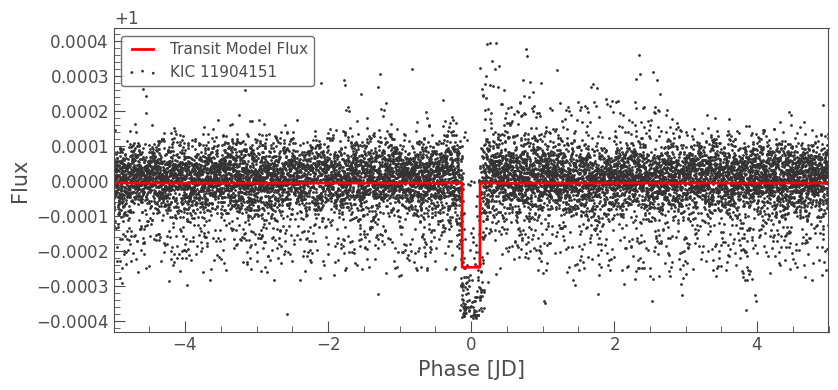

In [ ]:
# Create a BLS model using the BLS parameters
planet_b_model = bls.get_transit_model(period=planet_b_period,
                                       transit_time=planet_b_t0,
                                       duration=planet_b_dur)

ax = lc.fold(planet_b_period, planet_b_t0).scatter()
planet_b_model.fold(planet_b_period, planet_b_t0).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-5, 5);

plt.tight_layout()
plt.savefig(f'{obj}_exoplanet_package_transit_model.pdf')

#### Identifying additional transiting planet signals in the same light curve

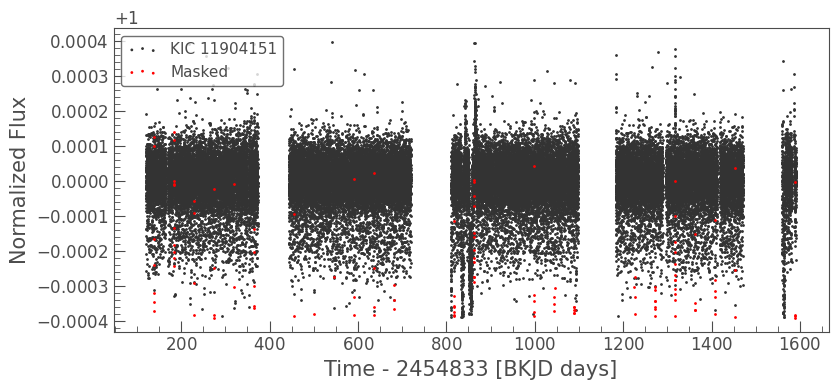

In [ ]:
# Create a cadence mask using the BLS parameters
planet_b_mask = bls.get_transit_mask(period=planet_b_period,
                                     transit_time=planet_b_t0,
                                     duration=planet_b_dur)

masked_lc = lc[~planet_b_mask]
ax = masked_lc.scatter();
lc[planet_b_mask].scatter(ax=ax, c='r', label='Masked');

plt.tight_layout()
plt.savefig(f'{obj}_masked.pdf')

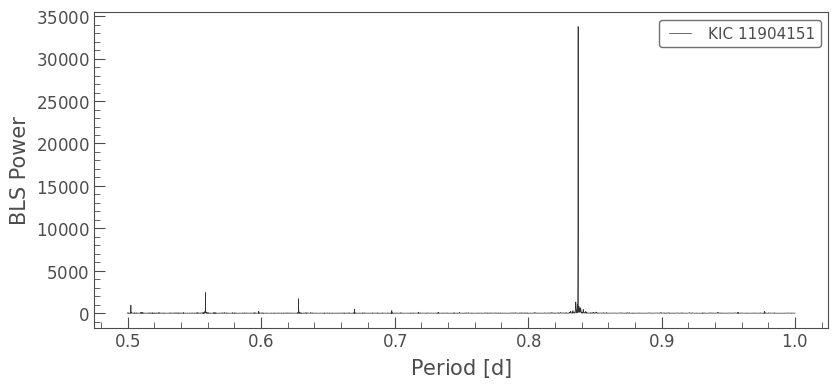

In [ ]:
periods = np.linspace(0.5, 1, 10000)
bls = masked_lc.to_periodogram(method = 'bls', 
                               period = periods, 
                               frequency_factor = 500
                               )
bls.plot();

plt.tight_layout()
plt.savefig(f'{obj}_masked_periodogram.pdf')

In [ ]:
planet_c_period = bls.period_at_max_power
planet_c_t0 = bls.transit_time_at_max_power
planet_c_dur = bls.duration_at_max_power
planet_c_depth = bls.depth_at_max_power

# Check the value for period
planet_c_period

<Quantity 0.83748375 d>

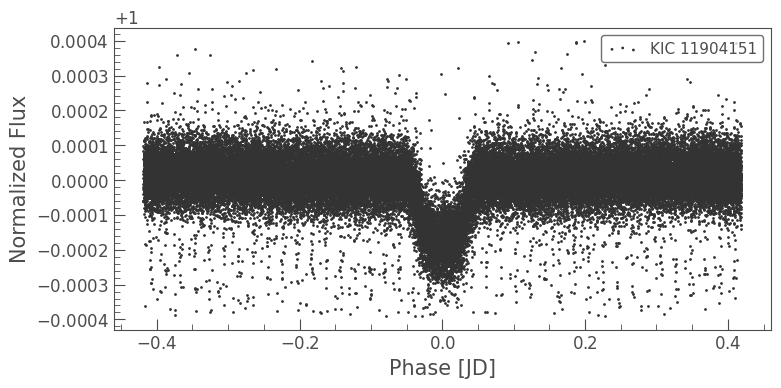

In [ ]:
ax = masked_lc.fold(planet_c_period, planet_c_t0).scatter()

# ax.set_xlim(-5, 5);

In [ ]:
planet_c_model = bls.get_transit_model(period=planet_c_period,
                                       transit_time=planet_c_t0,
                                       duration=planet_c_dur)

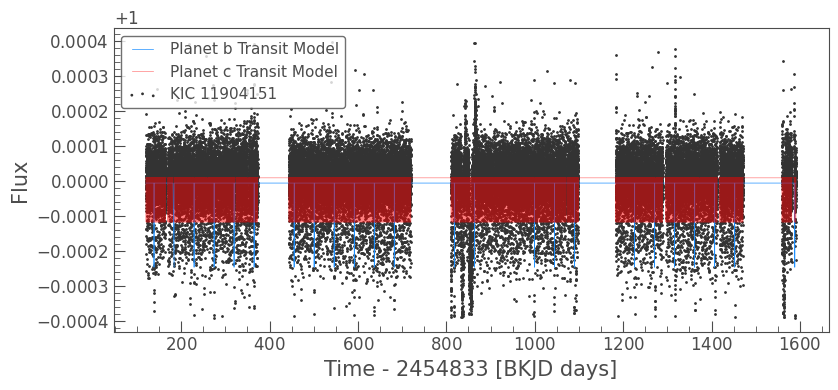

In [ ]:
ax = lc.scatter();
planet_b_model.plot(ax=ax, c='dodgerblue', label='Planet b Transit Model');
planet_c_model.plot(ax=ax, c='r', alpha = 0.5, label='Planet c Transit Model');

plt.tight_layout()
plt.savefig(f'{obj}_planets_b_c.pdf')

### Planet *c* model

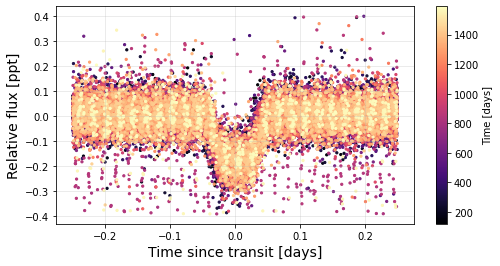

In [ ]:
x = np.ascontiguousarray(masked_lc.time.value, dtype = np.float64)
y = np.ascontiguousarray(1e3 * (masked_lc.flux - 1), dtype = np.float64)
yerr = np.ascontiguousarray(1e3 * masked_lc.flux_err, dtype = np.float64)


transit_mask = (
    np.abs(
        (x - planet_c_t0.value + 0.5 * planet_c_period.value) % planet_c_period.value - 0.5 * planet_c_period.value
    )
    < 0.25
)

x = np.ascontiguousarray(x[transit_mask])
y = np.ascontiguousarray(y[transit_mask])
yerr = np.ascontiguousarray(yerr[transit_mask])

plt.figure(figsize = (8, 4))

x_fold = (
    x - planet_c_t0.value + 0.5 * planet_c_period.value
) % planet_c_period.value - 0.5 * planet_c_period.value

plt.grid(alpha = 0.3)
plt.scatter(x_fold, y, c = x, s = 5, cmap = plt.cm.magma)
plt.xlabel('Time since transit [days]', fontsize = 14)
plt.ylabel('Relative flux [ppt]', fontsize = 14)
plt.colorbar(label = 'Time [days]')


In [ ]:
with pm.Model() as model:

    # STELLAR PARAMETERS
    mean = pm.Normal('mean', mu = 0, sigma = 10)
    u = xo.QuadLimbDark('u')
    star_params = [mean, u]

    # GAUSSIAN PROCESS NOISE MODEL
    sigma = pm.InverseGamma('sigma', alpha = 3.0, beta = 2 * np.median(yerr))
    log_sigma_gp = pm.Normal('log_sigma_gp', mu = 0.0, sigma = 10.0)
    
    log_rho_gp = pm.Normal('log_rho_gp', mu = np.log(10.0), sigma = 10.0)
    
    kernel = terms.SHOTerm(
        sigma=tt.exp(log_sigma_gp), rho=tt.exp(log_rho_gp), Q=1.0 / 3
    )

    noise_params = [sigma, log_sigma_gp, log_rho_gp]

    # PLANET PARAMETERS
    # RADIUS OF THE PLANET IN STELLAR RADII
    log_ror = pm.Normal(
        'log_ror', mu = 0.5 * np.log(planet_c_depth.value * 1e-3), sigma = 10.0
    )
    ror = pm.Deterministic('ror', tt.exp(log_ror))

    # ORBITAL PARAMETERS
    # A TRANSIT IS MODELLED BY period, t0, duration, impact parameter AND depth
    log_period = pm.Normal('log_period', mu = np.log(planet_c_period.value), sigma = 0.1)
    period = pm.Deterministic('period', tt.exp(log_period)) # ORBITAL PERIOD

    t0 = pm.Normal('t0', mu = planet_c_t0.value, sigma = 0.1) # TRANSIT TIME REFERENCE

    log_depth = pm.Normal('log_delta', mu = np.log(planet_c_depth.value), sigma = 0.1)
    depth = pm.Deterministic('depth', tt.exp(log_depth))

    log_dur = pm.Normal('log_dur', mu = np.log(0.1), sigma = 10.0)
    dur = pm.Deterministic('dur', tt.exp(log_dur)) # TRANSIT DURATION

    b = xo.distributions.ImpactParameter('b', ror = ror) # IMPACT PARAMETER

    # SET UP THE ORBIT
    orbit = xo.orbits.KeplerianOrbit(period = period, 
                                     duration = dur, 
                                     t0 = t0, 
                                     b = b)

    # WE ARE GOING TO TRACK THE IMPLIED DENSITY FOR PLOTTING PURPOSES
    pm.Deterministic('rhor_circ', orbit.rho_star)

    # SET UP THE MEAN TRANSIT MODEL
    star = xo.LimbDarkLightCurve(u)
    lc_model = mean + 1e3 * tt.sum(
        star.get_light_curve(orbit = orbit, 
                             r = ror, 
                             t = x), axis = -1)

    # THE GAUSSIAN PROCESS OBSERVATION MODEL
    gp = GaussianProcess(kernel, 
                         t = x, 
                         diag = yerr ** 2 + sigma ** 2)
    gp.marginal('obs', observed = y - lc_model) # CONDITION TO OBSERVATIONS

    # DOUBLE CHECK THAT EVERYTHING LOOKS GOOD 
    # WE SHOULDN'T SEE ANY NaNs
    print(model.check_test_point())

    # OPTIMISE THE MODEL
    map_soln = model.test_point
    map_soln = pmx.optimize(map_soln, [sigma])
    map_soln = pmx.optimize(map_soln, [ror, b, dur, depth])
    map_soln = pmx.optimize(map_soln, noise_params)
    map_soln = pmx.optimize(map_soln, star_params)
    map_soln = pmx.optimize(map_soln)

/usr/local/lib/python3.7/dist-packages/exoplanet/orbits/keplerian.py:113: UserWarning: When using the 'duration' parameter in KeplerianOrbit, the 'ror' parameter should also be provided.
  UserWarning,
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar

mean                   -3.22
u_quadlimbdark__       -2.77
sigma_log__            -0.53
log_sigma_gp           -3.22
log_rho_gp             -3.22
log_ror                -3.22
log_period              1.38
t0                      1.38
log_delta               1.38
log_dur                -3.22
b_impact__             -1.39
obs                 19958.58
Name: Log-probability of test_point, dtype: float64


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
optimizi

message: Optimization terminated successfully.
logp: 19941.934723204864 -> 30896.52843303041
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot cons

message: Desired error not necessarily achieved due to precision loss.
logp: 30896.52843303041 -> 37339.3503938856
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Ca

message: Desired error not necessarily achieved due to precision loss.
logp: 37339.3503938856 -> 41982.46745084705
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.te

message: Desired error not necessarily achieved due to precision loss.
logp: 41982.46745084705 -> 42176.01556152694
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): C

message: Desired error not necessarily achieved due to precision loss.
logp: 42176.01556152694 -> 44703.50768843696


In [ ]:
with model:
    lc_pred = pmx.eval_in_model(lc_model, map_soln)
    gp_pred = pmx.eval_in_model(gp.predict(y - lc_pred), map_soln)

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0


In [ ]:
with model:
    trace = pmx.sample(
        tune = 1000,
        draws = 1000,
        start = map_soln,
        chains = 2,
        cores = 2,
        return_inferencedata=True,
        random_seed=[286923464, 464329682] # 2 chains, 2 random seeds
    )

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3670 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt)

In [ ]:
smry = az.summary(
    trace, 
    var_names = ['^(?!rv_plot).*'], 
    filter_vars = 'regex'
)

smry

mean     sd   hdi_3%  ...  ess_bulk  ess_tail  r_hat
mean            0.006  0.001    0.004  ...    1983.0    1172.0   1.00
log_sigma_gp   -3.250  0.017   -3.282  ...    2159.0    1391.0   1.00
log_rho_gp     -0.301  0.059   -0.417  ...    2213.0    1266.0   1.00
log_ror        -4.021  0.071   -4.139  ...     389.0     331.0   1.01
log_period     -0.177  0.000   -0.177  ...    1865.0     960.0   1.01
t0            120.687  0.000  120.687  ...    1795.0     910.0   1.00
log_delta      -8.973  0.097   -9.146  ...    2776.0    1588.0   1.00
log_dur        -2.623  0.017   -2.653  ...     807.0     696.0   1.00
u[0]            0.599  0.418    0.001  ...     410.0     445.0   1.02
u[1]            0.123  0.384   -0.566  ...     579.0     479.0   1.02
sigma           0.034  0.000    0.033  ...    2457.0    1406.0   1.00
ror             0.018  0.001    0.016  ...     389.0     331.0   1.02
period          0.837  0.000    0.837  ...    1865.0     960.0   1.01
depth           0.000  0.000    0.000  ...    2776.0    1588.0   1.00
dur             0.073  0.001    0.070  ...     807.0     696.0   1.00
b               0.973  0.003    0.967  ...     472.0     403.0   1.01
rhor_circ       0.059  0.003    0.053  ...     433.0     245.0   1.01

[17 rows x 9 columns]

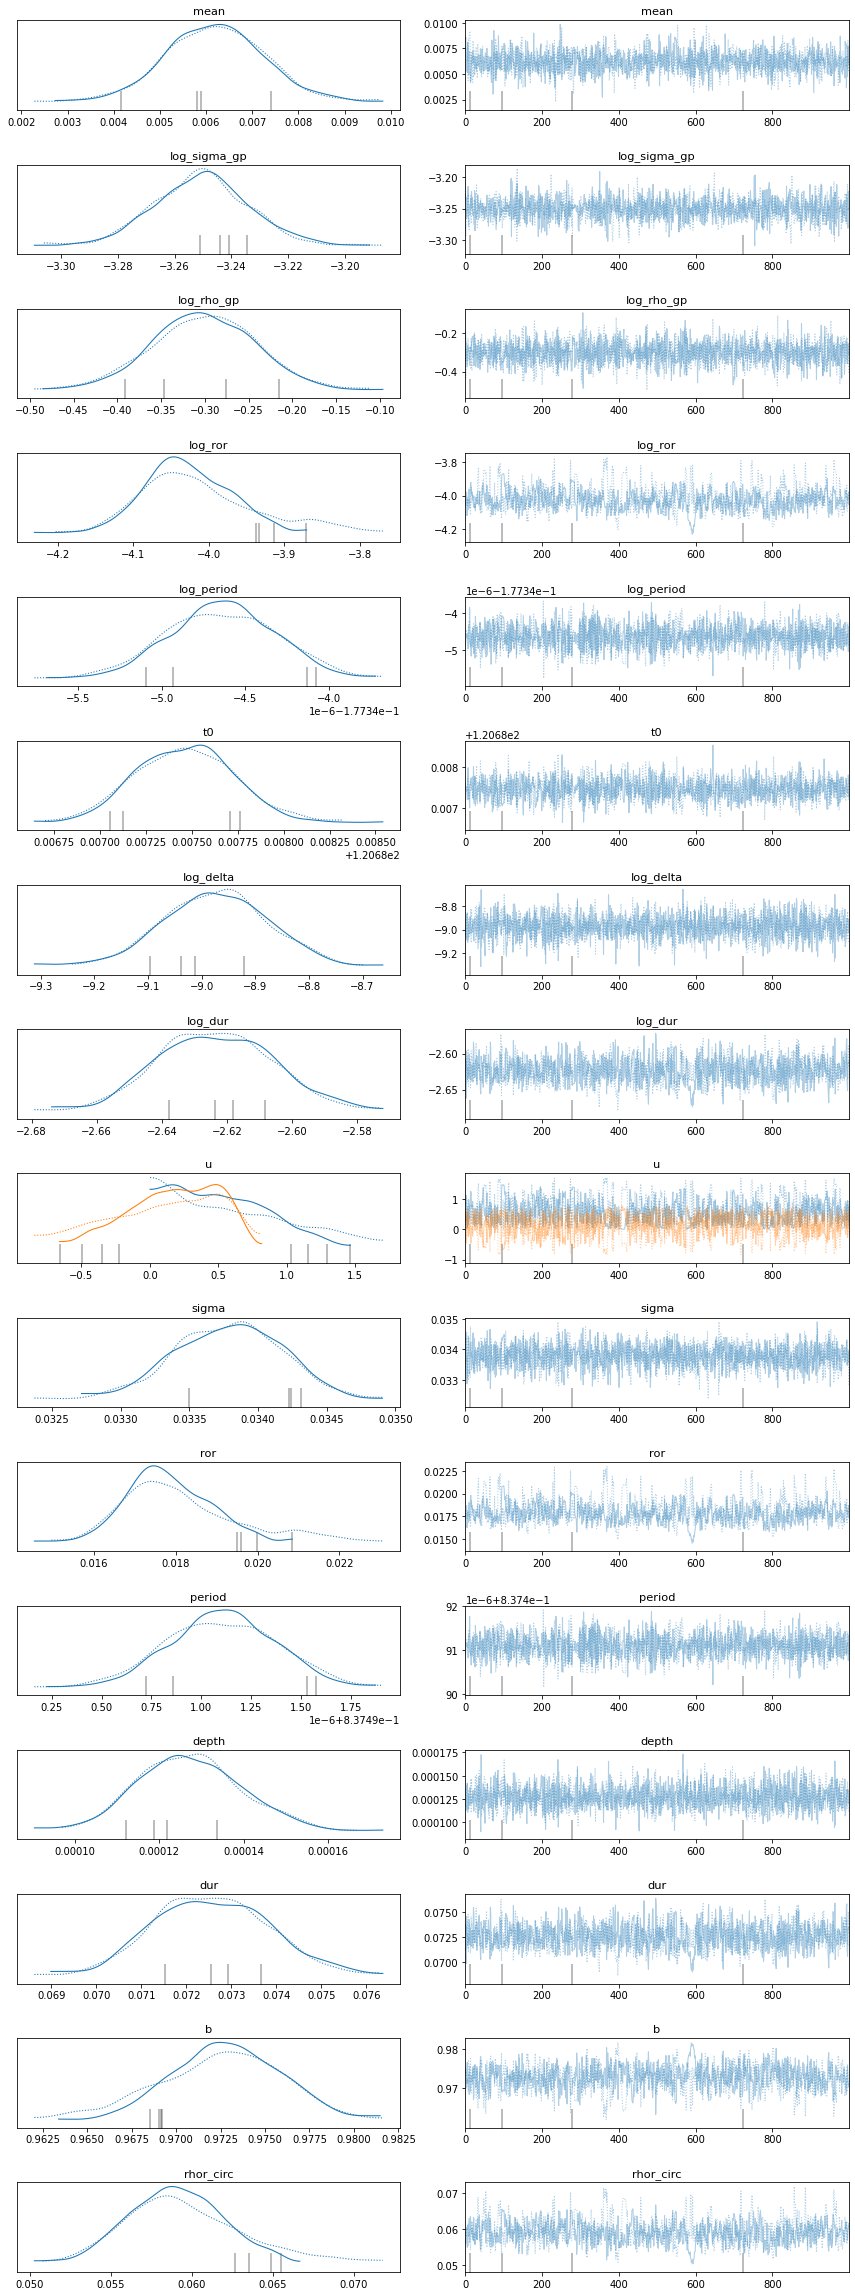

In [ ]:
_ = az.plot_trace(trace)

plt.tight_layout()
plt.savefig(f'{obj}c_arviz_trace.pdf')

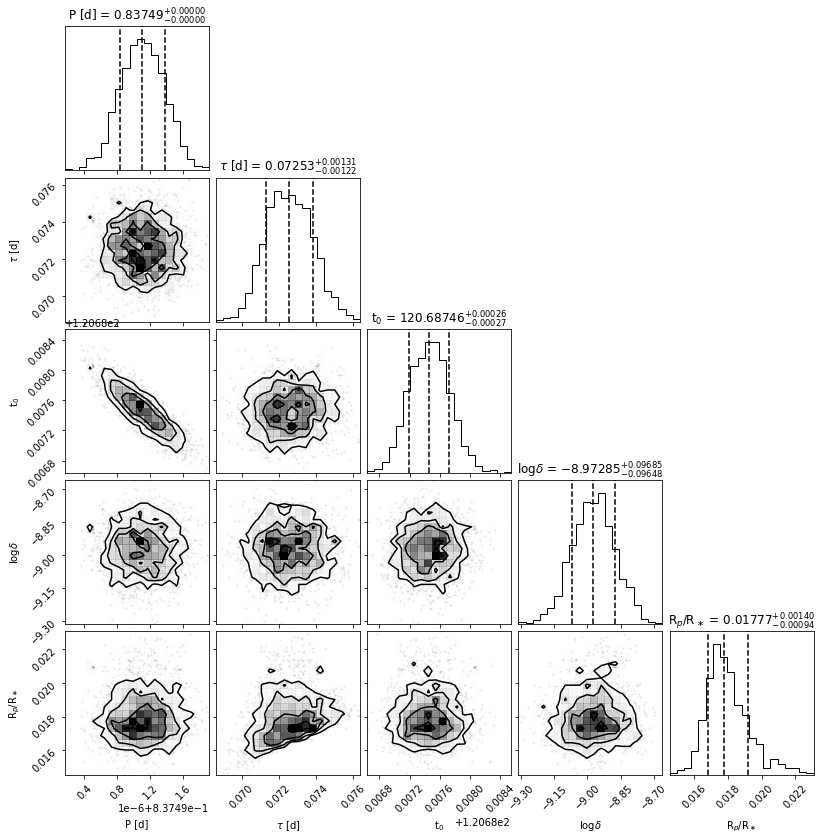

In [ ]:
_ = corner.corner(trace, 
                  var_names = ['period', 'dur', 't0', 'log_delta', 'ror'],
                  quantiles = [0.16, 0.5, 0.84], 
                  show_titles = True,
                  title_fmt = '.5f',
                  labels = ['P [d]', r'$\tau$ [d]', r't$_0$', r'$\log\delta$', r'R$_p$/R$_\ast$']
                  )

plt.savefig(f'{obj}c_corner.pdf')

In [ ]:
periods = np.percentile(trace['posterior']['period'], [16, 50, 84])
periods_q = np.diff(periods)

durations = np.percentile(trace['posterior']['dur'], [16, 50, 84])
durations_q = np.diff(durations)

ror = np.percentile(trace['posterior']['ror'], [16, 50, 84])
ror_q = np.diff(ror)

t0s = np.percentile(trace['posterior']['t0'], [16, 50, 84])
t0_q = np.diff(t0s)

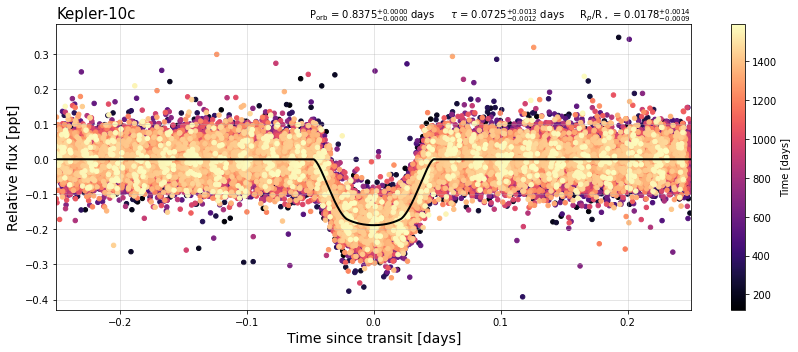

In [ ]:
plt.figure(figsize = (12, 5))

plt.grid(alpha = 0.4)

x_fold = (x - map_soln['t0'] + 0.5 * map_soln['period']) % map_soln[
    'period'
] - 0.5 * map_soln['period']

inds = np.argsort(x_fold)

plt.scatter(x_fold, 
            y - gp_pred - map_soln['mean'], 
            c = x, 
            s = 20, 
            cmap = plt.cm.magma)

plt.plot(x_fold[inds], 
         lc_pred[inds] - map_soln['mean'], 
         'k', 
         lw = 2.0)


plt.title(f'{obj}c', fontsize = 15, loc = 'left')
plt.title(r'P$_\mathrm{orb}$ = %.4f$^{+%.4f}_{-%.4f}$ days $\quad$ $\tau$ = %.4f$^{+%.4f}_{-%.4f}$ days $\quad$ R$_p$/R$_\star$ = %.4f$^{+%.4f}_{-%.4f}$'%(
          periods[1], periods_q[1], periods_q[0], 
          durations[1], durations_q[1], durations_q[0], 
          ror[1], ror_q[1], ror_q[0]), loc = 'right', fontsize = 10)

plt.xlabel('Time since transit [days]', fontsize = 14)
plt.ylabel('Relative flux [ppt]', fontsize = 14)
plt.colorbar(label = 'Time [days]')
_ = plt.xlim(-0.25, 0.25)

plt.tight_layout()
plt.savefig(f'{obj}c_transit_model.pdf')